In [8]:
%%capture
#%conda install -c plotly plotly=5.9.0
#%conda install pip
#%conda install twisted
%pip install plotly==5.9.0
%pip install twisted
%pip install pandas
%pip install scikit-learn
#%pip install huobi-sdk==2.3.3

import pandas as pd
import numpy as np    
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

import os
# Downloading latest pytrade2 data
#os.system("cd ./../deploy/yandex_cloud; ./download_data.sh")
data_dir=f"../data/yandex-cloud"
#print(f"Download completed. Local data dir: {data_dir}")

deploy_lib.sh: line 6: yc: command not found
INFO: Retrieving list of remote files for s3://pytrade2/data/ ...


Sync pytrade2 data from s3://pytrade2/data to /home/dima/projects/pytrade2/deploy/yandex_cloud/../../data/yandex-cloud


INFO: Cache file not found or empty, creating/populating it.
INFO: Compiling list of local files...
INFO: Running stat() and reading/calculating MD5 values on 29 files, this may take some time...
INFO: Found 28 remote files, 29 local files
INFO: Verifying attributes...
INFO: disabled md5 check for SimpleKerasStrategy/Xy/2023-12-16_BTC-USDT_raw_bid_ask.csv.zip
INFO: disabled md5 check for SimpleKerasStrategy/Xy/2023-12-17_BTC-USDT_raw_bid_ask.csv.zip
INFO: disabled md5 check for SimpleKerasStrategy/Xy/2023-12-17_BTC-USDT_x.csv.zip
INFO: Summary: 9 remote files to download, 1 local files to delete, 0 local files to hardlink


download: 's3://pytrade2/data/LongCandleDenseStrategy/Xy/2023-12-17_BTC-USDT_raw_candles_1min.csv.zip' -> '/home/dima/projects/pytrade2/deploy/yandex_cloud/../../data/yandex-cloud/LongCandleDenseStrategy/Xy/2023-12-17_BTC-USDT_raw_candles_1min.csv.zip'  [1 of 9]
 1859600 of 1859600   100% in    2s   799.01 KB/s  done
download: 's3://pytrade2/data/LongCandleDenseStrategy/Xy/2023-12-17_BTC-USDT_x.csv.zip' -> '/home/dima/projects/pytrade2/deploy/yandex_cloud/../../data/yandex-cloud/LongCandleDenseStrategy/Xy/2023-12-17_BTC-USDT_x.csv.zip'  [2 of 9]
 320280 of 320280   100% in    0s   676.87 KB/s  done
download: 's3://pytrade2/data/LongCandleDenseStrategy/Xy/2023-12-17_BTC-USDT_y.csv.zip' -> '/home/dima/projects/pytrade2/deploy/yandex_cloud/../../data/yandex-cloud/LongCandleDenseStrategy/Xy/2023-12-17_BTC-USDT_y.csv.zip'  [3 of 9]
 48674 of 48674   100% in    0s   407.00 KB/s  done
download: 's3://pytrade2/data/LongCandleDenseStrategy/Xy/2023-12-17_BTC-USDT_y_pred.csv.zip' -> '/home/dima/p

Error: no such table: trade
Error: no such table: trade


In [12]:
symbol="BTC-USDT"

In [13]:
from pathlib import Path

def read_candles(days = 1, period = '1min'):
    """ Read last days' 1 min candles from file system """

    candles_dir = Path(data_dir, 'LongCandleDenseStrategy', 'Xy')
    files = sorted([f for f in os.listdir(candles_dir) if f.endswith(f"candles_{period}.csv.zip")])
    # Read last days' files to one dataframe
    df = pd.concat([pd.read_csv(Path(candles_dir, fname), parse_dates=['open_time', 'close_time']) for fname in files[-days:]])
    df = df.set_index('close_time', drop=False)
    del(df['close_time.1']) # temp fix
    # Resample because row data contains multiple candles inside a period
    return df.resample('1min').agg('last')

candles = read_candles(1)
candles.tail()

,close_time,open_time,ticker,interval,open,high,low,close,vol
close_time,,,,,,,,,
2023-12-17 18:51:00,2023-12-17 18:51:59.239,2023-12-17 18:50:59.239,BTC-USDT,1min,42173.0,42173.0,42150.9,42161.2,8010.0
2023-12-17 18:52:00,2023-12-17 18:52:59.028,2023-12-17 18:51:59.028,BTC-USDT,1min,42161.1,42163.9,42152.2,42163.9,624.0
2023-12-17 18:53:00,2023-12-17 18:53:56.279,2023-12-17 18:52:56.279,BTC-USDT,1min,42181.6,42181.6,42159.9,42171.7,4516.0
2023-12-17 18:54:00,2023-12-17 18:54:49.916,2023-12-17 18:53:49.916,BTC-USDT,1min,42171.8,42171.8,42155.1,42160.9,370.0
2023-12-17 18:55:00,2023-12-17 18:55:22.004,2023-12-17 18:54:22.004,BTC-USDT,1min,42160.9,42166.5,42160.9,42166.4,160.0


In [14]:
import matplotlib.pyplot as plt

def plot_value_counts(ax, df, col, grouped):
    signals = df[col]
    #vc = signals[signals.diff() != 0].value_counts()
    vc = df[col].value_counts() if not grouped else signals[(signals.diff() != 0) & (signals != 0)].value_counts()
    label_map={0:'oom', 1:'buy', -1: 'sell'}
    color_map={'oom':'C0', 'buy': 'C1', 'sell': 'C2'}
    labels = [ label_map[signal] for signal in vc.index.tolist()]
    colors = [color_map[key] for key in labels]
    ax.pie(vc, labels = labels,  autopct= lambda x: '{:.0f}'.format(x*vc.sum()/100), colors = colors)
    tag = 'groups' if grouped else ''
    ax.set_title(f"{col} {tag}")
    
def plot_signal_counts(df):
    fig, (ax1, ax2) = plt.subplots(1, 2) 
    plot_value_counts(ax1, df, 'signal', grouped = False)
    plot_value_counts(ax2, df, 'signal', grouped = True)
    fig.suptitle(f'Signal counts from {df.index.min()} to {df.index.max()}')
    plt.show()

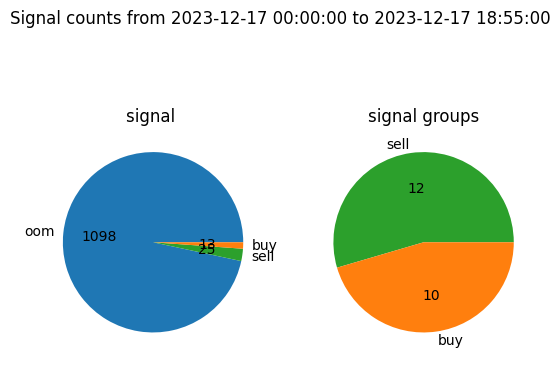

In [27]:

def calc_signal(candles, predict_window, open_ratio, min_profit_ratio, max_loss_ratio, comission_pct=0.012):
    """ Signal -1,0,1 plus extended debugging info """
    #next_candles = candles[['open', 'high', 'low', 'close', 'vol']].shift(1)

    next_candles = pd.DataFrame(index=candles.index)
    next_candles[['high', 'low']] = (candles[['high', 'low']][::-1]
                                     .rolling(predict_window).agg({'high' : 'max', 'low' : 'min'})
                                     [::-1])

    # BTC-USDT 40 000 * 1% = 400
    # BTC-USDT 40 000 * 0.012% = 40 * 0.012 = 4,8
    comission = comission_pct*0.01*2 # Order open, order close, double comission
    # Ratio to open: generate signal if profit/loss > open ratio
    #open_ratio = 1
    min_profit = candles['close']*(max(comission*2, min_profit_ratio))
    
    # Profit / loss > open ratio considering comission and minimal profit
    profit_buy = (next_candles['high'] - candles['high']) - (candles['close']*2*comission)
    loss_buy =  (candles['high'] - next_candles['low']) + (candles['close']*2*comission)
    signal_buy = (profit_buy > 0) & ((profit_buy / loss_buy) > open_ratio)& (profit_buy > min_profit)
    
    # Profit / loss > open ratio considering comission and minimal profit
    profit_sell = (candles['low'] - next_candles['low']) - (candles['close']*2*comission)
    loss_sell = (next_candles['high'] - candles['low']) + (candles['close']*2*comission)
    signal_sell = (profit_sell > 0) & ((profit_sell / loss_sell) > open_ratio) & (profit_sell > min_profit)

    # Signal
    signal = pd.DataFrame(index=candles.index)
    signal['signal'] = 0  # Default to 0
    signal.loc[signal_buy & ~signal_sell, 'signal'] = 1  # Set to 1 where 'buy' is True and 'sell' is False
    signal.loc[~signal_buy & signal_sell, 'signal'] = -1  # Set to -1 where 'sell' is True and 'buy' is False

    df = signal
    # Expected profit and loss
    df.loc[signal['signal']==1, 'profit'] = profit_buy
    df.loc[signal['signal']==1, 'loss'] = loss_buy
    df.loc[signal['signal']==-1, 'profit'] = profit_sell
    df.loc[signal['signal']==-1, 'loss'] = loss_sell
    return df
    # df[['high', 'low', 'close']] = candles[['high','low', 'close']]
    # df[['next_high', 'next_low']] = next_candles[['high', 'low']]
    # df['min_profit'] = min_profit
    # df['profit_buy'] = profit_buy
    # df['loss_buy']  = loss_buy
    # df['profit_buy_ratio'] = profit_buy / loss_buy
    # df['profit_sell'] = profit_sell
    # df['loss_sell']  = loss_sell
    # df['profit_sell_ratio'] = profit_sell / loss_sell

    # #df = df[(profit_buy / loss_buy) > open_ratio]
    
    # df['signal'] = signal['signal']
    # # df['buy ratio'] = profit_buy/loss_buy
    
    # return df

signal = (calc_signal(candles, 
                      predict_window = '10min', 
                      open_ratio = 4, 
                      # 0.01*0.012*2 - open+close comission 0.012%
                      # Comission is 4.8 for 40K price, ~10 for one open+close trade
                      min_profit_ratio = (0.01*0.012*2)*2,
                      max_loss_ratio = (0.01*0.012*2) * 10)
         )
signal[signal['signal']!=0].tail(100)

plot_signal_counts(signal)